# Sentiment Analysis with LSTM

Import Dependencies + Settings

In [72]:
%store -r initial_processing_df

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, SimpleRNN, Embedding, LSTM
#from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix
#from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.models import load_model

from tqdm import tqdm
#from textblob import TextBlob
#from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.sentiment import vader, SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from collections import Counter


import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import keras
#import random
import nltk
import re

np.random.seed(124)
tf.random.set_seed(124)

plt.style.use('ggplot')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nawid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nawid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nawid\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Training Dataset Preprocessing

In [2]:
# Loading the data
df = pd.read_csv('../Examensarbete_DS21/rnn_hotel_training_data.csv', encoding='ISO-8859-1')
df.shape

(27330, 6)

In [3]:
# Let's have a look at our dataset
df.head()

,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review
0,Apex London Wall Hotel,5,Ottima qualità prezzo,Siamo stati a Londra per un week end ed abbiam...,"Casale Monferrato, Italy",10/20/2012
1,Corinthia Hotel London,5,"By far, my best hotel in the world",I had a pleasure of staying in this hotel for ...,"Savannah, Georgia",3/23/2016
2,The Savoy,5,First visit to the American Bar at the Savoy,A very lovely first visit to this iconic hotel...,London,7/30/2013
3,Rhodes Hotel,4,Nice stay,3 of us stayed at the Rhodes Hotel for 4 night...,"Maui, Hawaii",6/2/2012
4,The Savoy,5,Perfection,Form the moment we arrived until we left we ex...,"London, United Kingdom",11/24/2017


In [4]:
# We only need the review text and raiting
df = df[['Review Text', 'Review Rating']]
df

,Review Text,Review Rating
0,Siamo stati a Londra per un week end ed abbiam...,5
1,I had a pleasure of staying in this hotel for ...,5
2,A very lovely first visit to this iconic hotel...,5
3,3 of us stayed at the Rhodes Hotel for 4 night...,4
4,Form the moment we arrived until we left we ex...,5
...,...,...
27325,I come to London often but since I stayed in t...,5
27326,En cuarto que nos tocó no había toallas y habí...,3
27327,This is a quality quiet hotel located in an ex...,4
27328,"Väldigt vackra rum, tyvärr med en mycket höglj...",4


In [5]:
# Checking for null values.
df.isna().any()

Review Text      False
Review Rating    False
dtype: bool

## Positive Column

In [6]:
# If rating [1, 2, 3] = Negative and if rating [4, 5] = Positive
def ratings(rating):
    if rating>0 and rating<=3:
        return 0
    if rating>3 and rating<=5:
        return 1
    
df['Positive'] = df['Review Rating'].apply(ratings)
df.head()

,Review Text,Review Rating,Positive
0,Siamo stati a Londra per un week end ed abbiam...,5,1
1,I had a pleasure of staying in this hotel for ...,5,1
2,A very lovely first visit to this iconic hotel...,5,1
3,3 of us stayed at the Rhodes Hotel for 4 night...,4,1
4,Form the moment we arrived until we left we ex...,5,1


## Word Count Column

In [7]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word_count'] = df['Review Text'].apply(word_count)
df.head()

,Review Text,Review Rating,Positive,Word_count
0,Siamo stati a Londra per un week end ed abbiam...,5,1,171
1,I had a pleasure of staying in this hotel for ...,5,1,265
2,A very lovely first visit to this iconic hotel...,5,1,54
3,3 of us stayed at the Rhodes Hotel for 4 night...,4,1,75
4,Form the moment we arrived until we left we ex...,5,1,62


# NLTK Text Processing Function

In [8]:
def preprocess_text(sen):
    '''Cleans up text data, leaving 2 or more char long non-stopwords containing A-Z & a-z only in lowercase'''

    sentence = sen.lower()
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Remove single characters that are not part of words with more than one character
    sentence = re.sub(r"\b[a-zA-Z]\b", '', sentence)
    
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = sentence.split()
    filtered_words = [word for word in words if not word in stop_words]
    
    return ' '.join(filtered_words)


# EDA

In [9]:
df.describe()

,Review Rating,Positive,Word_count
count,27330.000000,27330.000000,27330.000000
mean,4.490999,0.890853,128.819539
std,0.891704,0.311830,128.600239
min,1.000000,0.000000,1.000000
25%,4.000000,1.000000,55.000000
50%,5.000000,1.000000,91.000000
75%,5.000000,1.000000,156.000000
max,5.000000,1.000000,5781.000000


## Count of Reviews by Stars

In [10]:
df['Review Rating'].value_counts()

Review Rating
5    18327
4     6020
3     1675
2      691
1      617
Name: count, dtype: int64

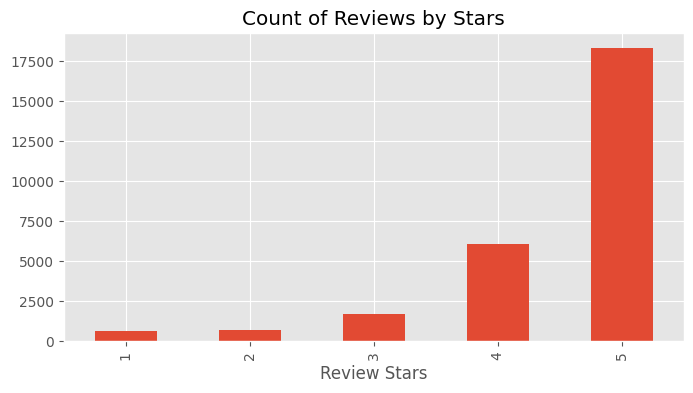

In [11]:
ax = df['Review Rating'].value_counts().sort_index().plot(
    kind='bar',
    title='Count of Reviews by Stars',
    figsize=(8, 4)
)
ax.set_xlabel('Review Stars')
plt.show()

The dataset consists of a significant number of positive reviews.

## Count of Reviews by Positive

In [12]:
df['Positive'].value_counts()

Positive
1    24347
0     2983
Name: count, dtype: int64

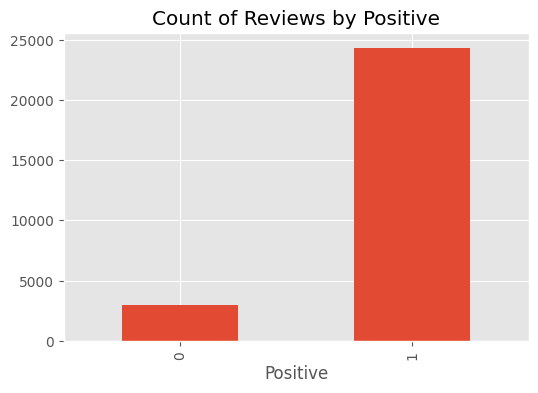

In [13]:
ax = df['Positive'].value_counts().sort_index().plot(
    kind='bar',
    title='Count of Reviews by Positive',
    figsize=(6, 4)
)
ax.set_xlabel('Positive')
plt.show()

The distribution of data is highly skewed towards positive reviews.

### Word Count by Review Rating

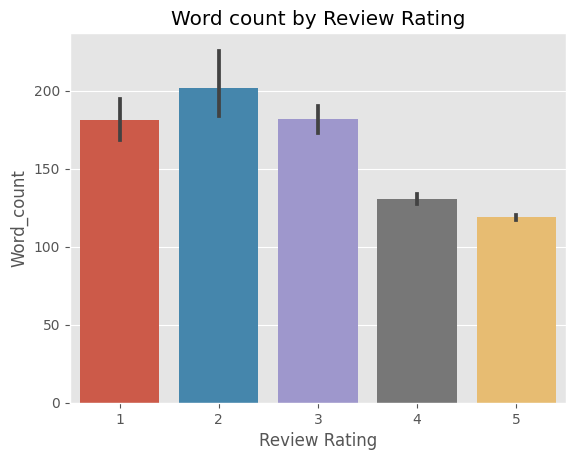

In [14]:
ax = sns.barplot(df, x='Review Rating', y='Word_count')
ax.set_title('Word count by Review Rating')
plt.show()

Based on the graph, it can be inferred that the number of words decreases as the star rating increases. This is not surprising, as people tend to have more to say when they are dissatisfied.

## Term Frequency

### Corpus
To analyze the most frequent words in the reviews, we will create a function called corpus(). This function will convert the review text into a list of words. However, before doing so, we need to clean the text using the preprocess_text function created earlier using the NLTK library. The cleaning process includes removing punctuations, numbers, single characters, multiple spaces, and stopwords.

In [15]:
# Empty list where the cleaned text will be stored
clean_text = []

clean_sentences = list(df['Review Text'])
for sen in tqdm(clean_sentences):
    clean_text.append(preprocess_text(sen))

100%|██████████| 27330/27330 [00:07<00:00, 3530.81it/s]


In [16]:
# A function that takes the review text and splits all the words
def corpus(text):
    test_list = text.split()
    return test_list

# Convert the clean_text list to a pandas Series object
clean_text_series = pd.Series(clean_text)

# Applies the corpus function on the review text and then saves into a new column
df['Corpus_Reviews'] = clean_text_series.apply(corpus)
df.head()

,Review Text,Review Rating,Positive,Word_count,Corpus_Reviews
0,Siamo stati a Londra per un week end ed abbiam...,5,1,171,"[siamo, stati, londra, per, un, week, end, ed,..."
1,I had a pleasure of staying in this hotel for ...,5,1,265,"[pleasure, staying, hotel, nights, recently, h..."
2,A very lovely first visit to this iconic hotel...,5,1,54,"[lovely, first, visit, iconic, hotel, bar, won..."
3,3 of us stayed at the Rhodes Hotel for 4 night...,4,1,75,"[us, stayed, rhodes, hotel, nights, great, loc..."
4,Form the moment we arrived until we left we ex...,5,1,62,"[form, moment, arrived, left, experienced, abs..."


## Frequently occuring N_grams
Most frequently occurring n-grams
What is an n-gram? An n-gram is a sequence of n words in a text. Most words by themselves may not present the entire context. Typically, adverbs such as 'most' or 'very' are used to modify verbs and adjectives. Therefore, n-grams help analyze phrases and not just words, which can lead to better insights.

Some examples of n-grams are:

- bi-gram, which means two words in a sequence, such as 'very good' or 'too great'.
- tri-gram, which means three words in a sequence, such as 'how was your day'. This would be broken down to 'how was your' and 'was your day'.
- quad-gram, which means four words in a sequence.
- quint-gram, which means five words in a sequence.

### Top 15 Words

In [17]:
# Create an empty list to store all words in the corpus
all_words = []

# Iterate over each review in the corpus and add all words to the all_words list
for review in df['Corpus_Reviews']:
    all_words.extend(review)
    
# Count the frequency of each word and get the 10 most common words
word_freq = Counter(all_words)
top_words = word_freq.most_common(15)

# Print the 10 most common words
print("The 10 most frequent words in the corpus are:")
for word, freq in top_words:
    print(f"{word}: {freq}")

The 10 most frequent words in the corpus are:
hotel: 39554
room: 30251
staff: 18144
london: 15577
stay: 14150
service: 12920
great: 12509
breakfast: 11799
good: 10914
would: 10792
one: 9896
us: 9518
rooms: 8923
stayed: 8919
location: 8671


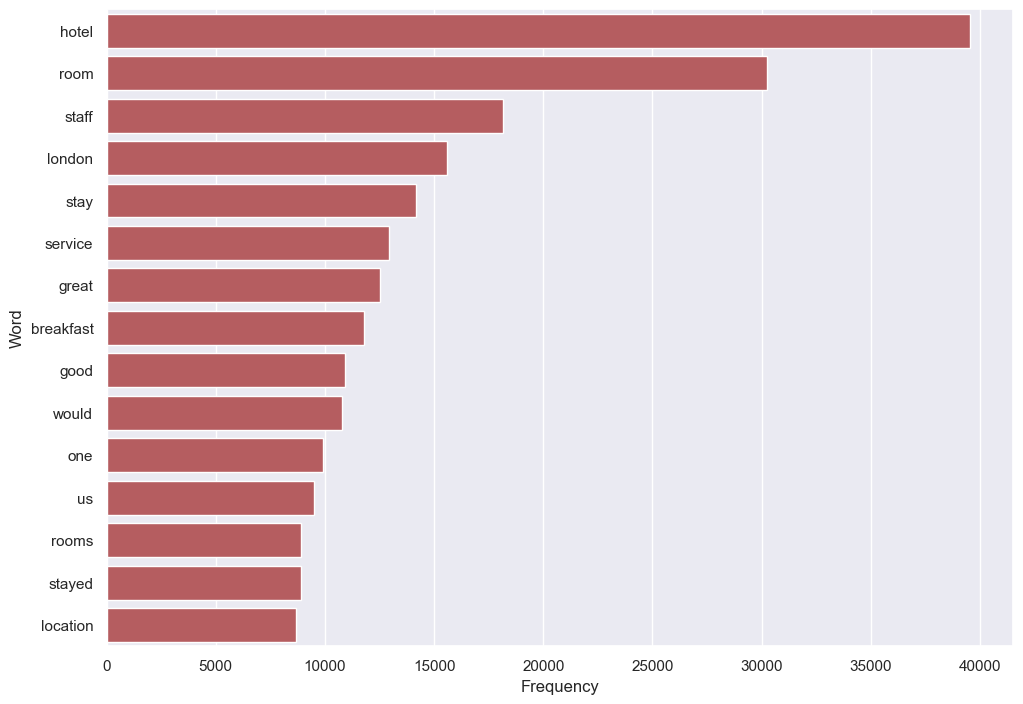

In [18]:
word_freq = Counter(all_words)
top_words = word_freq.most_common(15)

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=[val[1] for val in top_words], y=[val[0] for val in top_words], color='r')
ax.set_xlabel('Frequency')
ax.set_ylabel('Word')
plt.show()

### Bi-gram

In [19]:
# Create an empty list to store all bi-grams in the corpus
all_bigrams = []

# Iterate over each review in the corpus and add all bi-grams to the all_bigrams list
for review in df['Corpus_Reviews']:
    bigrams = ngrams(review, 2)
    all_bigrams.extend(list(bigrams))

# Count the frequency of each bi-gram and get the 10 most common bi-grams
bigram_freq = Counter(all_bigrams)
top_bigrams = bigram_freq.most_common(15)

# Print the 15 most common bi-grams
print("The 15 most frequent bi-grams in the corpus are:")
for bigram, freq in top_bigrams:
    print(f"{bigram}: {freq}")

The 15 most frequent bi-grams in the corpus are:
('afternoon', 'tea'): 1782
('staff', 'friendly'): 1660
('hyde', 'park'): 1608
('room', 'service'): 1480
('great', 'location'): 1378
('one', 'night'): 1355
('walking', 'distance'): 1234
('friendly', 'helpful'): 1228
('american', 'bar'): 1156
('would', 'definitely'): 1119
('tube', 'station'): 1062
('highly', 'recommend'): 1040
('recommend', 'hotel'): 1013
('hotel', 'staff'): 937
('front', 'desk'): 883


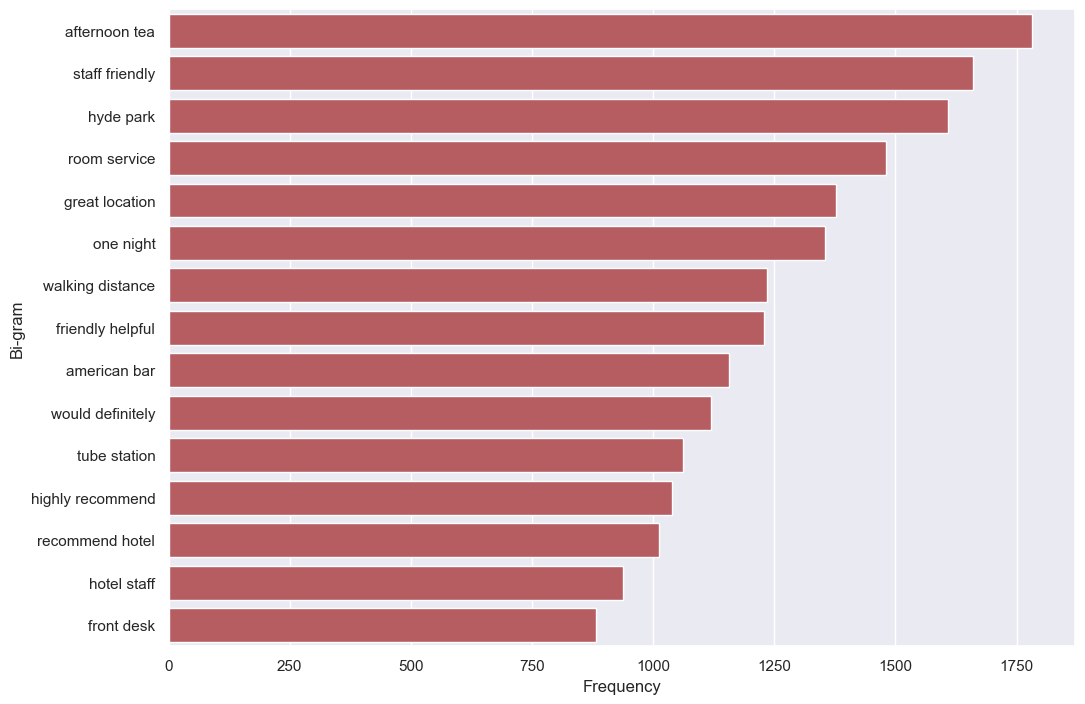

In [20]:
# Convert the tuples to strings
top_bigrams_str = [f"{bigram[0]} {bigram[1]}" for bigram, freq in top_bigrams]

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=[val[1] for val in top_bigrams], y=top_bigrams_str, color='r')
ax.set_xlabel('Frequency')
ax.set_ylabel('Bi-gram')
plt.show()

### Tri-gram

In [21]:
# Create an empty list to store all tri-grams in the corpus
all_trigrams = []

# Iterate over each review in the corpus and add all tri-grams to the all_trigrams list
for review in df['Corpus_Reviews']:
    trigrams = ngrams(review, 3)
    all_trigrams.extend(list(trigrams))
    
# Count the frequency of each tri-gram and get the 10 most common tri-grams
trigram_freq = Counter(all_trigrams)
top_trigrams = trigram_freq.most_common(15)

# Print the 15 most common tri-grams
print("The 15 most frequent tri-grams in the corpus are:")
for trigram, freq in top_trigrams:
    print(f"{trigram}: {freq}")


The 15 most frequent tri-grams in the corpus are:
('staff', 'friendly', 'helpful'): 550
('nothing', 'much', 'trouble'): 505
('stayed', 'one', 'night'): 484
('within', 'walking', 'distance'): 458
('would', 'highly', 'recommend'): 444
('would', 'definitely', 'stay'): 440
('apex', 'london', 'wall'): 348
('hotel', 'great', 'location'): 340
('made', 'us', 'feel'): 325
('would', 'definitely', 'recommend'): 314
('south', 'kensington', 'tube'): 299
('highly', 'recommend', 'hotel'): 275
('victoria', 'albert', 'museum'): 269
('worth', 'every', 'penny'): 250
('would', 'recommend', 'hotel'): 248


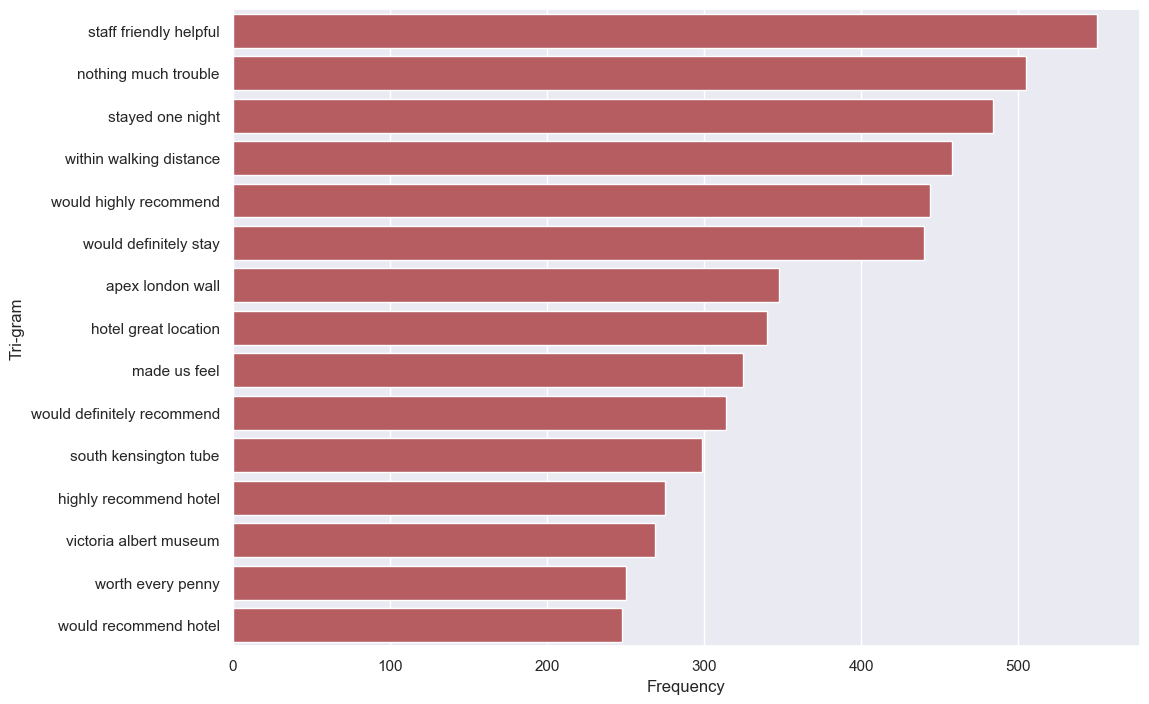

In [22]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=[val[1] for val in top_trigrams], y=[f"{val[0][0]} {val[0][1]} {val[0][2]}" for val in top_trigrams], color='r')
ax.set_xlabel('Frequency')
ax.set_ylabel('Tri-gram')
plt.show()

### Top 15 Bad Words

In [23]:
text = ' '.join(clean_text)  # join the list of strings using a space as separator

# Initialize the sentiment analyzer
analyzer = vader.SentimentIntensityAnalyzer()

# Tokenize the text into individual words
words = word_tokenize(text)

# Get the negative words
negative_words = []
for word in tqdm(words):
    score = analyzer.polarity_scores(word)['neg']
    if score > 0.5:  # Threshold for negative sentiment
        negative_words.append(word)
        
word_freq = Counter(negative_words)
top_words = word_freq.most_common(15)

100%|██████████| 1880113/1880113 [00:27<00:00, 67696.42it/s]


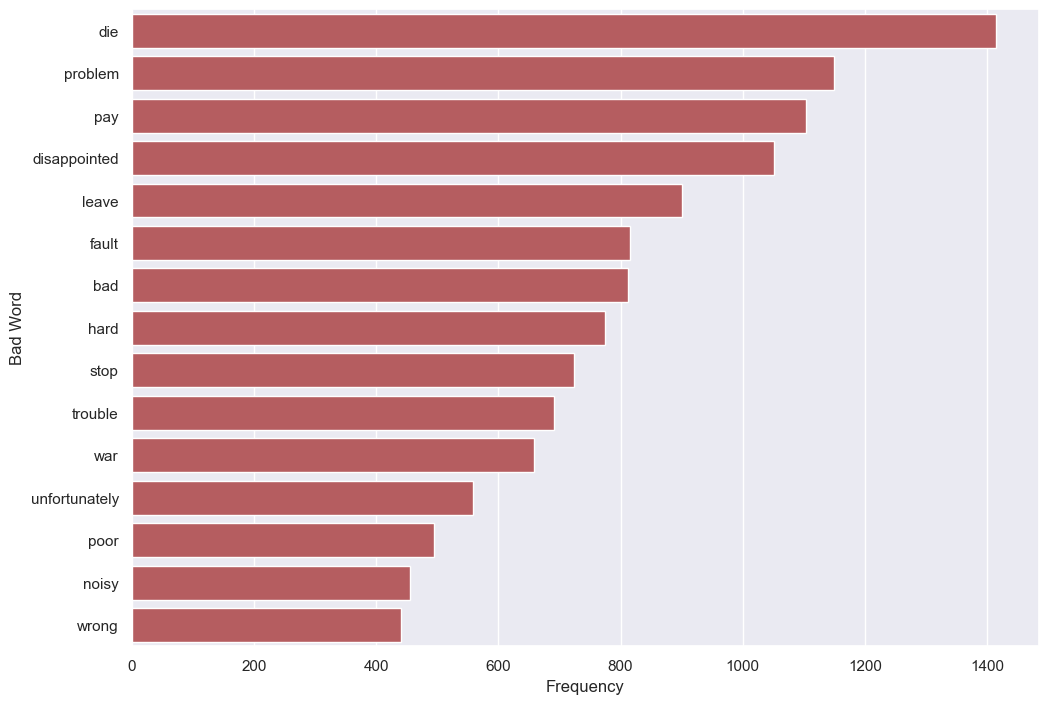

In [24]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=[val[1] for val in top_words], y=[val[0] for val in top_words], color='r')
ax.set_xlabel('Frequency')
ax.set_ylabel('Bad Word')
plt.show()

### Bi-gram of Bad Words

In [25]:
# Create a bi-gram of the words
bigrams = ngrams(words, 2)

# Convert the bigrams into strings
bigram_strings = [' '.join(bigram) for bigram in bigrams]

# Get the negative bigrams
negative_bigrams = []
for bigram in tqdm(bigram_strings):
    score = analyzer.polarity_scores(bigram)['neg']
    if score > 0.5:  # Threshold for negative sentiment
        negative_bigrams.append(bigram)
bigram_freq = Counter(negative_bigrams)
top_bigrams = bigram_freq.most_common(15)


100%|██████████| 1880112/1880112 [00:43<00:00, 42918.10it/s]


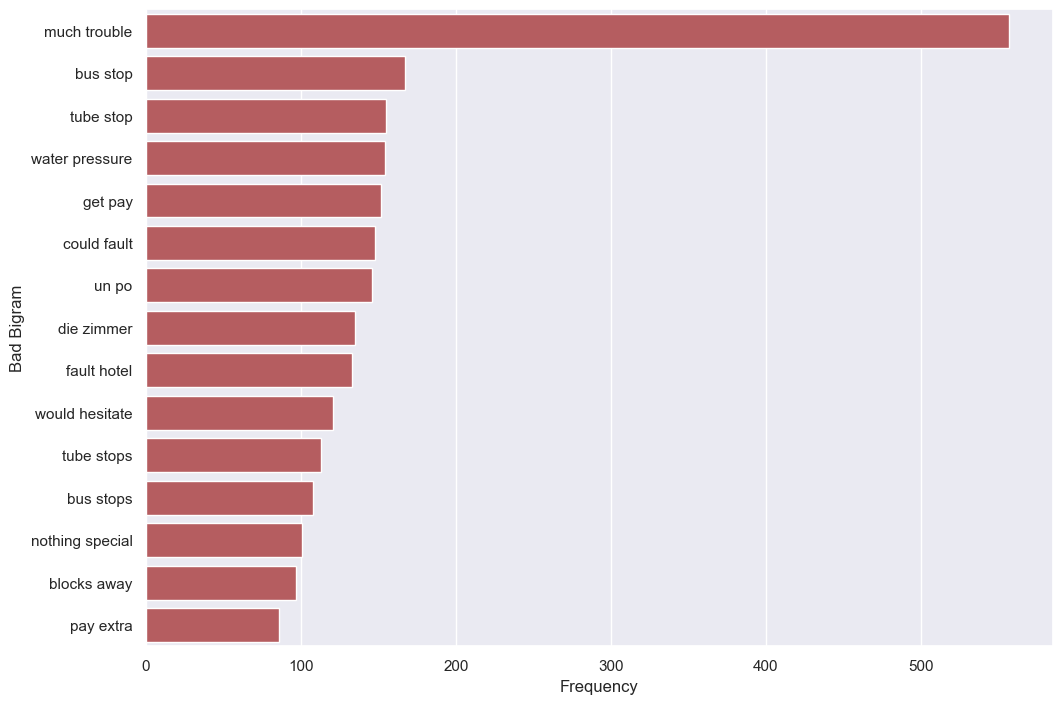

In [26]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=[val[1] for val in top_bigrams], y=[val[0] for val in top_bigrams], color='r')
ax.set_xlabel('Frequency')
ax.set_ylabel('Bad Bigram')
plt.show()

### Tri-gram of Bad Words

In [27]:
# Create tri-grams
trigrams = ngrams(words, n=3)

# Convert the trigrams into strings
trigram_strings = [' '.join(trigram) for trigram in trigram]

# Get the negative words
negative_trigrams = []
for trigram in tqdm(trigrams):
    score = analyzer.polarity_scores(' '.join(trigram))['neg']
    if score > 0.5:  # Threshold for negative sentiment
        negative_trigrams.append(' '.join(trigram))
        
        
# Get the top 15 bad tri-negative_trigrams
trigram_freq = Counter(negative_trigrams)
top_trigram = trigram_freq.most_common(15)


1880111it [00:59, 31533.57it/s]


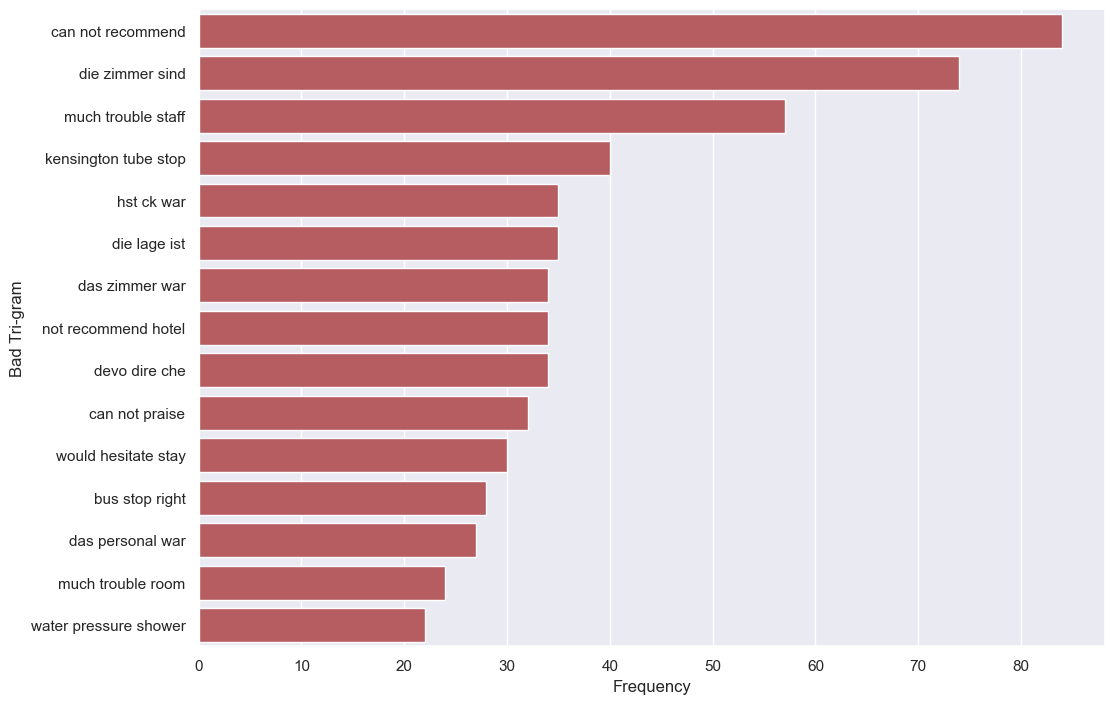

In [28]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=[val[1] for val in top_trigram], y=[val[0] for val in top_trigram], color='r')
ax.set_xlabel('Frequency')
ax.set_ylabel('Bad Tri-gram')
plt.show()

# Prepering for model

It's apparent that the reviews vary in lengths, which is problematic. Neural networks cannot accept data of different lengths. Therefore, it is imperative that we standardize the length of each review. To accomplish this, we need to:

* Split data into train test
* Determine a fxied number of word.
* Tokenize the words.
* Pad the text.
* One-hot encode Y
* Reshape data from 2D to 3D

## Split Data into Train Test

In [29]:
# Cleaning review text which will then be saved to x

x = []

sentences = list(df['Review Text'])
for sen in sentences:
    x.append(preprocess_text(sen))

In [30]:
#x = df['Review Text']
x = np.array(x)
y = df['Positive']

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print("shape of x_train:", x_train.shape)
print("shape of x_test:", x_test.shape)

print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)


shape of x_train: (21864,)
shape of x_test: (5466,)
shape of y_train: (21864,)
shape of y_test: (5466,)


## Determine Number of Words

In [32]:
# Checking mean and std
df["Word_count"].describe()

count    27330.000000
mean       128.819539
std        128.600239
min          1.000000
25%         55.000000
50%         91.000000
75%        156.000000
max       5781.000000
Name: Word_count, dtype: float64

### Visual Inspection

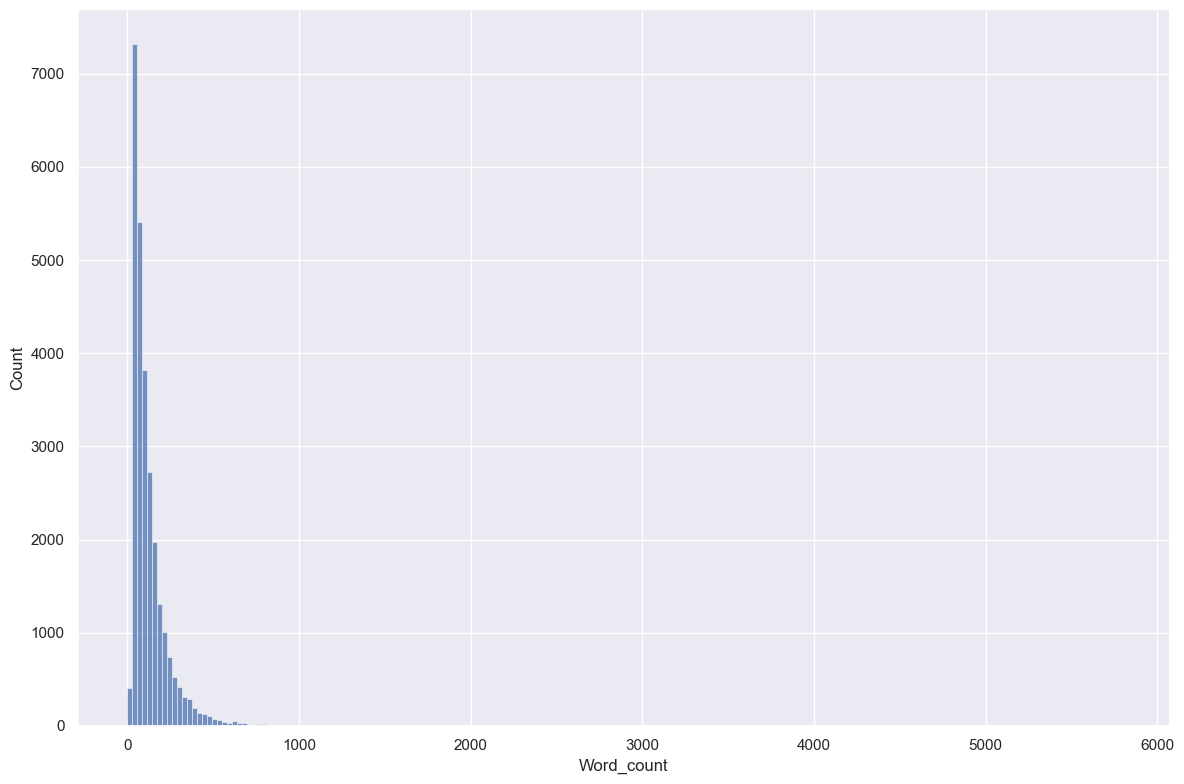

In [33]:
sns.displot(df["Word_count"], height=8, aspect=1.5, bins=200)

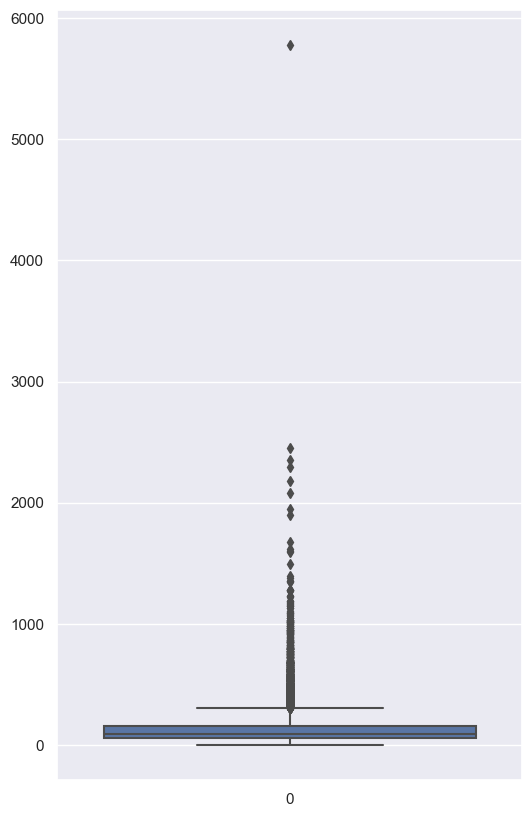

In [34]:
plt.figure(figsize=(6, 10))
sns.boxplot(df["Word_count"])
plt.show()

Upon careful examination of both visuals, it becomes apparent that around 350 words represents the optimal maximum word count.

### IQR Method
To ensure accuracy, I will also use the IQR method to verify the validity or proximity of my observation.

In [35]:
q1 = df["Word_count"].quantile(0.25)
q3 = df["Word_count"].quantile(0.75)
iqr = q3-q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

upper_limit, lower_limit

print(f'The upper limit, which is {upper_limit}, closely aligns with my observation. Therefore, I will round it up to 350.')

The upper limit, which is 307.5, closely aligns with my observation. Therefore, I will round it up to 350.


## Tokenizing the text. Creates a word-to-index dictionary

Once a word is tokenized, the assigned number represents its frequency within the text. The number 1 corresponds to the most frequently occurring word, and so forth.

In [36]:
# This is what the words look like before getting tokenized
print(x_train[4])
print(y_train[4])

wife stayed aplex london wall november come one night stay special treat anniversary hotel close liverpool station bank tube station heart city really nice welcome reception anh glass chilled prosseco given room balcony nice view city room verybig great facilitiesandalovely coffee machine realcoffeeforonce thebed nicely presented swans made towels heart shape made red petals also received aplex branded box chocolates bathrobes fluffy slippers romantic indeed room clean huge comfortable bed white crisp sheets nice feather ducks pillows impressed man point view condition room items paint ac mastic shower drain etc pristine condition impressive normally see hotel room nowadays declined service secondhand thoughts accepted see wife enjoyed massive stand bath decorated rose petals nicetoiletries elemis brand white fluffy towels food delicious service quick overall amazing experience worth every penny paid definitely return longer stay also recommend friends family
1


In [37]:
# Let's check what our vocabulary size is
tokenizer = Tokenizer()

tokenizer.fit_on_texts(x_train.copy())

VOCAB_SIZE = len(tokenizer.word_index)
print("Vocabulary size:", VOCAB_SIZE)

Vocabulary size: 52005


In [38]:
VOCAB_SIZE = 52005

#, lower=True
tokenizer = Tokenizer(VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

# Providing each token an integer
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [39]:
# This is what the words look like after beeing tokenized
print(x_train[4])
print(y_train[4])

[204, 14, 19813, 4, 397, 1725, 154, 11, 21, 5, 67, 224, 387, 1, 92, 1060, 78, 360, 68, 78, 768, 129, 24, 18, 214, 81, 26801, 518, 2428, 8457, 217, 2, 472, 18, 69, 129, 2, 26802, 7, 26803, 128, 785, 26804, 26805, 713, 649, 5721, 48, 559, 768, 3405, 48, 1546, 2274, 26, 487, 19813, 5393, 1351, 987, 2225, 1747, 936, 1578, 931, 2, 32, 239, 31, 43, 932, 2602, 1726, 18, 4308, 7620, 670, 478, 353, 481, 69, 2021, 2, 828, 3135, 952, 19814, 75, 4238, 165, 4154, 2021, 686, 1296, 133, 1, 2, 5563, 2429, 6, 26806, 5101, 3010, 133, 204, 127, 1160, 1165, 166, 391, 1660, 2274, 26807, 2022, 1269, 932, 1747, 559, 29, 196, 6, 521, 167, 47, 42, 153, 63, 1004, 483, 66, 125, 961, 5, 26, 54, 346, 185]
1


## Padding the text

* If a review exceeds 350 words, we will remove the excess words.
* If a review contains less than 350 words, we will append zeros to it until it reaches a length of 750 words.

In [40]:
# Word lenghts before padding
len(x_train[0]), len(x_train[1]), len(x_train[2]), len(x_train[3]), len(x_train[4])

(27, 73, 66, 57, 137)

In [41]:
# Max length of words
MAXLEN = 350

x_train = keras.utils.pad_sequences(x_train, padding='post', maxlen=MAXLEN)
x_test = keras.utils.pad_sequences(x_test, padding='post', maxlen=MAXLEN)

In [42]:
# Word lenghts after padding
len(x_train[0]), len(x_train[1]), len(x_train[2]), len(x_train[3]), len(x_train[4])

(350, 350, 350, 350, 350)

In [43]:
# And this is what it looks like if we take a closer look
x_train[4]

array([  204,    14, 19813,     4,   397,  1725,   154,    11,    21,
           5,    67,   224,   387,     1,    92,  1060,    78,   360,
          68,    78,   768,   129,    24,    18,   214,    81, 26801,
         518,  2428,  8457,   217,     2,   472,    18,    69,   129,
           2, 26802,     7, 26803,   128,   785, 26804, 26805,   713,
         649,  5721,    48,   559,   768,  3405,    48,  1546,  2274,
          26,   487, 19813,  5393,  1351,   987,  2225,  1747,   936,
        1578,   931,     2,    32,   239,    31,    43,   932,  2602,
        1726,    18,  4308,  7620,   670,   478,   353,   481,    69,
        2021,     2,   828,  3135,   952, 19814,    75,  4238,   165,
        4154,  2021,   686,  1296,   133,     1,     2,  5563,  2429,
           6, 26806,  5101,  3010,   133,   204,   127,  1160,  1165,
         166,   391,  1660,  2274, 26807,  2022,  1269,   932,  1747,
         559,    29,   196,     6,   521,   167,    47,    42,   153,
          63,  1004,

## One-Hot Encoding on y

In [44]:
# The assigned number is dependent on the type of rating being used, which is currently set to 0 or 1 in this instance.
# However, it is possible to modify this if you have multilabel.
num_classes = 2

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_test[0])

(21864, 2)
[0. 1.]


## Resaping the data from 2D to 3D

Recurrent Neural Networks (RNNs) require 3D input because they are designed to operate on sequences of data. The 3D input tensor consists of a batch size, sequence length, and feature dimensions.

* Batch size: The number of sequences in a batch, typically represented as the first dimension of the 3D tensor.
* Sequence length: The number of time steps in each sequence, represented as the second dimension of the 3D tensor.
* Feature dimensions: The number of features or variables in each time step, represented as the third dimension of the 3D tensor.

The 3D input tensor allows RNNs to process a sequence of data over time, where each time step contains a set of features. By using a 3D input, RNNs can learn and remember patterns and dependencies across multiple time steps, which is useful in a variety of applications such as natural language processing, speech recognition, and time series forecasting.

In [45]:
x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape)
print("Sentences:", x_train.shape[0], "Words:", x_train.shape[1], "TimeSteps:", x_train.shape[2], "\n")
print(x_test.shape)
print("Sentences:", x_test.shape[0], "Words:", x_test.shape[1], "TimeSteps:", x_test.shape[2])

(21864, 350, 1)
Sentences: 21864 Words: 350 TimeSteps: 1 

(5466, 350, 1)
Sentences: 5466 Words: 350 TimeSteps: 1


# Model Building

In [46]:
# NN Model
model = tf.keras.Sequential([
tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=50, input_length=MAXLEN),
tf.keras.layers.LSTM(32, return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.LSTM(16, return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 50)           2600250   
                                                                 
 lstm (LSTM)                 (None, 350, 32)           10624     
                                                                 
 dropout (Dropout)           (None, 350, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 350, 16)           3136      
                                                                 
 dropout_1 (Dropout)         (None, 350, 16)           0         
                                                                 
 flatten (Flatten)           (None, 5600)              0         
                                                                 
 dense (Dense)               (None, 2)                 1

## Weights

We are dealing with imbalanced data. It's important to adjust the weights of the classes to reflect their distribution. This can be done by calculating the class weights and passing them to the model during training.

The class weights can be calculated using various techniques such as inverse frequency, inverse square root frequency, or user-defined weights. Inverse frequency assigns a weight to each class that is inversely proportional to the number of samples in that class. Inverse square root frequency assigns a weight that is the inverse square root of the frequency of the class. User-defined weights allow the user to manually assign weights to each class based on their domain knowledge.

I opted for inverse frequency as you can seee below.

In [47]:
# Frequency
freq = pd.value_counts(df['Positive'])
freq

Positive
1    24347
0     2983
Name: count, dtype: int64

In [48]:
# Inverse frequency
weights = {0: freq.sum() / freq[0], 1: freq.sum() / freq[1]}
weights

{0: 9.161917532685216, 1: 1.122520228364891}

## ModelCheckpoint

In [49]:
# Creating checkpoint that saves the best model
checkpoint = ModelCheckpoint('model/', save_best_only=True)
#, monitor='val_accuracy', mode='max'

# Stop the training if the val_loss does not improve on next 4 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

# Creates a csv file and saves the model metrics in it
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

# A lsit with the 3 instances that will be put into callbacks in model.fit()
callback_lsit = [checkpoint, early_stop, log_csv]

## Training Model

In [50]:
# Creating an instance of BinaryCrossentropy to pass into model.compile()
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Configure the model for training.
model.compile(optimizer=Adam(learning_rate=(0.0001)), loss=loss_fn, metrics=['accuracy', AUC(name='AUC')])

# Train a model
history = model.fit(x_train, y_train, batch_size=150, epochs=20, validation_split=0.20, class_weight=weights, callbacks=[callback_lsit])

# print the best epoch
print(f"The best epoch is {early_stop.best_epoch}.")

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 1.3811 - accuracy: 0.7639 - AUC: 0.7908

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


117/117 [==============================] - 64s 528ms/step - loss: 1.3811 - accuracy: 0.7639 - AUC: 0.7908 - val_loss: 0.6602 - val_accuracy: 0.6499 - val_AUC: 0.6585
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 1.2731 - accuracy: 0.6563 - AUC: 0.6973

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


117/117 [==============================] - 56s 478ms/step - loss: 1.2731 - accuracy: 0.6563 - AUC: 0.6973 - val_loss: 0.5800 - val_accuracy: 0.7094 - val_AUC: 0.7767
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.8597 - AUC: 0.9226

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


117/117 [==============================] - 65s 558ms/step - loss: 0.6936 - accuracy: 0.8597 - AUC: 0.9226 - val_loss: 0.2187 - val_accuracy: 0.9165 - val_AUC: 0.9708
Epoch 4/20
117/117 [==============================] - 57s 487ms/step - loss: 0.3734 - accuracy: 0.9296 - AUC: 0.9742 - val_loss: 0.2426 - val_accuracy: 0.9076 - val_AUC: 0.9657
Epoch 5/20
117/117 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.9487 - AUC: 0.9851

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


117/117 [==============================] - 64s 551ms/step - loss: 0.2720 - accuracy: 0.9487 - AUC: 0.9851 - val_loss: 0.2155 - val_accuracy: 0.9202 - val_AUC: 0.9742
Epoch 6/20
117/117 [==============================] - 65s 560ms/step - loss: 0.2077 - accuracy: 0.9628 - AUC: 0.9906 - val_loss: 0.3383 - val_accuracy: 0.8863 - val_AUC: 0.9502
Epoch 7/20
117/117 [==============================] - 66s 568ms/step - loss: 0.1659 - accuracy: 0.9696 - AUC: 0.9930 - val_loss: 0.2368 - val_accuracy: 0.9227 - val_AUC: 0.9743
Epoch 8/20
117/117 [==============================] - 65s 557ms/step - loss: 0.1249 - accuracy: 0.9775 - AUC: 0.9947 - val_loss: 0.2427 - val_accuracy: 0.9206 - val_AUC: 0.9728
Epoch 9/20
117/117 [==============================] - 65s 553ms/step - loss: 0.1016 - accuracy: 0.9832 - AUC: 0.9964 - val_loss: 0.2791 - val_accuracy: 0.9200 - val_AUC: 0.9687
Epoch 9: early stopping
The best epoch is 4.


# LSTM Model Scores and Evaluation

Let's evaluate the model to see how well it did

In [51]:
best_model = load_model('model/')

test_predictions = (best_model.predict(x_test) > 0.5).astype(int)
print(classification_report(y_test, test_predictions, zero_division=0))

171/171 [==============================] - 8s 44ms/step
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       579
           1       0.97      0.95      0.96      4887

   micro avg       0.92      0.92      0.92      5466
   macro avg       0.79      0.83      0.81      5466
weighted avg       0.93      0.92      0.92      5466
 samples avg       0.92      0.92      0.92      5466



TODO: The precision and recall for both classes are high, indicating that the model is able to correctly identify both positive and negative cases. The f1-score is also high for both classes, which suggests that the model has a good balance between precision and recall.

The macro and weighted average scores are also high, which indicates that the model is performing well overall.

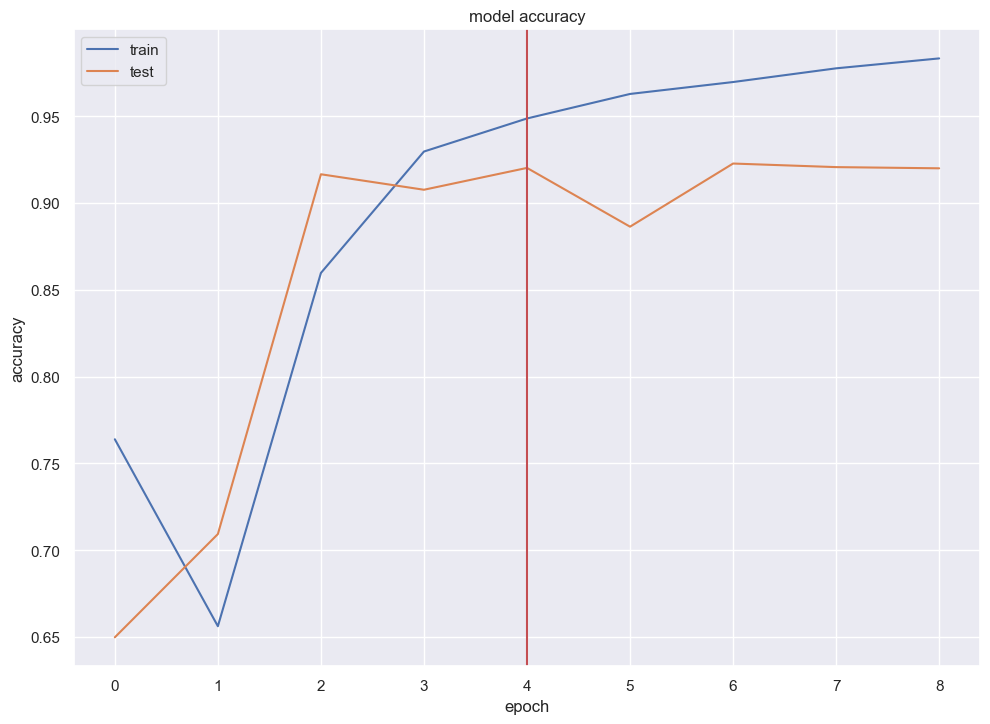

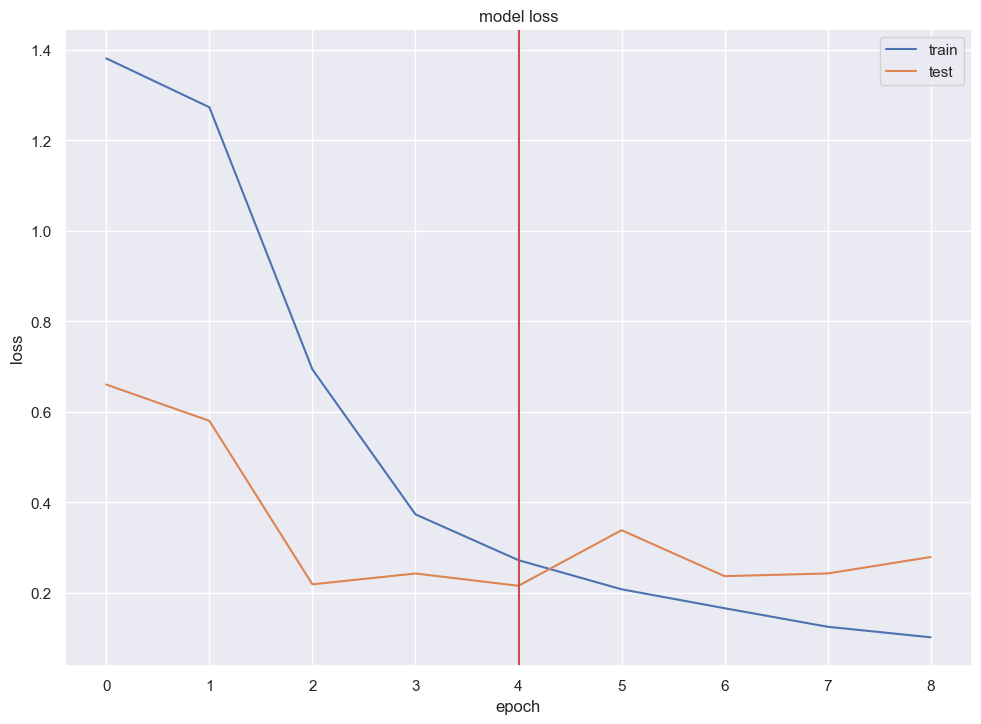

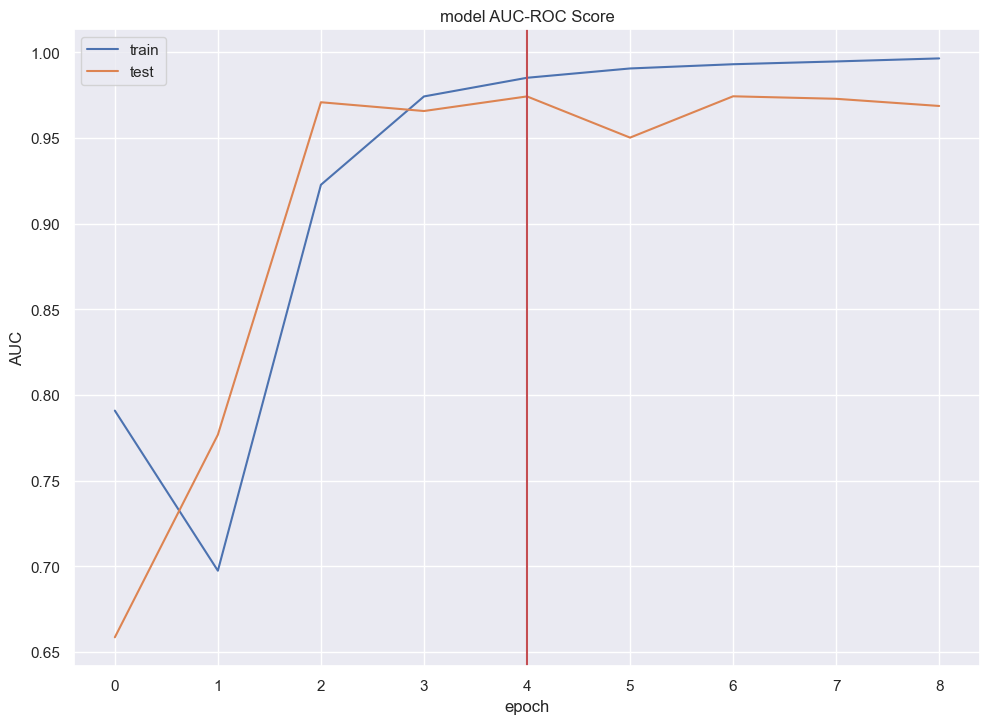

In [52]:
# Model Performance Chart

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Add a marker on best epoch
plt.axvline(x=early_stop.best_epoch, color='r')

plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# Add a marker on best epoch
plt.axvline(x=early_stop.best_epoch, color='r')

plt.show()

# AUC
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])

plt.title('model AUC-ROC Score')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Add a marker on best epoch
plt.axvline(x=early_stop.best_epoch, color='r')

plt.show()


In [54]:
print(f'Looking at this output at best epoch, the accuracy score for the training set is {history.history["accuracy"][early_stop.best_epoch]:.2f}%, while the accuracy score for the validation set is {history.history["val_accuracy"][early_stop.best_epoch]:.2f}%. This suggests that the model is performing well and not overfitting too much to the training data. The loss scores are also decreasing with each epoch, which is a good sign that the model is learning from the data.')

Looking at this output at best epoch, the accuracy score for the training set is 0.95%, while the accuracy score for the validation set is 0.92%. This suggests that the model is performing well and not overfitting too much to the training data. The loss scores are also decreasing with each epoch, which is a good sign that the model is learning from the data.


TODO: make this a comment instead with f string that gets the score and round it


Looking at this output, the accuracy score for the training set is around 89-90%, while the accuracy score for the validation set is around 90-91%. This suggests that the model is performing well and not overfitting too much to the training data. The loss scores are also decreasing with each epoch, which is a good sign that the model is learning from the data.


Great! The ROC AUC score of my model is 0.901998439517365 which indicates that my model is performing well. A value of 0.5 indicates random guessing, while a value of 1 indicates perfect performance. A score between 0.7 to 0.9 is considered good, while a score above 0.9 is considered excellent. Therefore, I would say my model is performing well in terms of its ability to distinguish between positive and negative samples.

### Confusion Mtrix

In [55]:
# Create the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), test_predictions.argmax(axis=1))

print(cm)

[[ 417  162]
 [ 270 4617]]


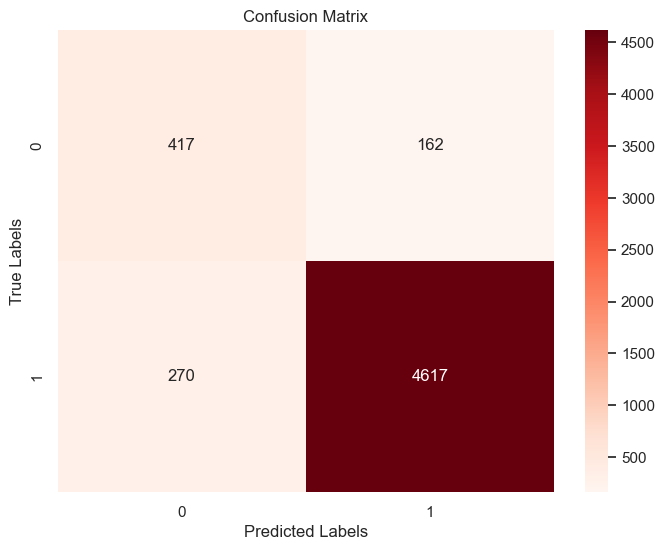

In [56]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Confusion Matrix Summarized

In [57]:
print('Based on the output, the confusion matrix has four values - true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP).')
print(f'- Here, the model predicted {cm[0][0]} true negatives and {cm[1][1]} true positives. It also predicted {cm[0][1]} false positives and {cm[1][0]} false negatives.')

Based on the output, the confusion matrix has four values - true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP).
- Here, the model predicted 417 true negatives and 4617 true positives. It also predicted 162 false positives and 270 false negatives.


# Making Predictions with LSTM Model

Next, we will utilize our neural network to predict the sentiment of our own reviews. However, since the reviews are encoded, we need to convert our new reviews into the same encoding format so that the network can process them. To accomplish this, we will load the encodings from the existing dataset and apply them to our new data.

In [73]:
data = initial_processing_df
data.shape

(20491, 5)

In [74]:
data.head()

,Review,Rating,Positive,Character_Count,Word_count
0,nice hotel expensive parking got good deal sta...,4,1,593,87
1,ok nothing special charge diamond member hilto...,2,0,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,0,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,1,600,89
4,"great stay great stay, went seahawk game aweso...",5,1,1281,191


In [75]:
# Empty list where the cleaned text will be stored
data_clean_text = []

data_clean_sentences = list(data['Review'])
for sen in tqdm(data_clean_sentences):
    data_clean_text.append(preprocess_text(sen))

100%|██████████| 20491/20491 [00:05<00:00, 3922.06it/s]


In [76]:
data_tokenized = tokenizer.texts_to_sequences(data_clean_text)
data_padded = keras.utils.pad_sequences(data_tokenized, padding='post', maxlen=MAXLEN)

In [77]:
best_model = load_model('model/')

# Use the model to make predictions
data_predictions = best_model.predict(data_padded)


641/641 [==============================] - 27s 42ms/step


In [78]:
# Get the predicted class labels
data_class_predictions = np.argmax(data_predictions, axis=1)

# Create a DataFrame with the predicted class labels
data_predictions_df = pd.DataFrame(data_class_predictions, columns=['LSTM_Prediction_Positive'])

# Concatenate the original DataFrame with the new predictions DataFrame
data = pd.concat([data, data_predictions_df], axis=1)

In [79]:
# Let's evaluate the model to see how well it did
print(classification_report(data['Positive'], data['LSTM_Prediction_Positive']))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      5398
           1       0.92      0.92      0.92     15093

    accuracy                           0.88     20491
   macro avg       0.84      0.84      0.84     20491
weighted avg       0.88      0.88      0.88     20491



In [80]:
data.head()

,Review,Rating,Positive,Character_Count,Word_count,LSTM_Prediction_Positive
0,nice hotel expensive parking got good deal sta...,4,1,593,87,1
1,ok nothing special charge diamond member hilto...,2,0,1689,250,0
2,nice rooms not 4* experience hotel monaco seat...,3,0,1427,217,1
3,"unique, great stay, wonderful time hotel monac...",5,1,600,89,1
4,"great stay great stay, went seahawk game aweso...",5,1,1281,191,1


## Comparing True Positives Against LSTM Prediction

In [81]:
# function to compare values in two columns and return boolean
def check_cols(df:str, col1:str, col2:str):
    return df[col1] == df[col2]

In [82]:
# apply function to each row using the apply method
data['Positive_VS_LSTM_Positive'] = data.apply(lambda x: check_cols(x, 'Positive', 'LSTM_Prediction_Positive'), axis=1)

data.head()

,Review,Rating,Positive,Character_Count,Word_count,LSTM_Prediction_Positive,Positive_VS_LSTM_Positive
0,nice hotel expensive parking got good deal sta...,4,1,593,87,1,True
1,ok nothing special charge diamond member hilto...,2,0,1689,250,0,True
2,nice rooms not 4* experience hotel monaco seat...,3,0,1427,217,1,False
3,"unique, great stay, wonderful time hotel monac...",5,1,600,89,1,True
4,"great stay great stay, went seahawk game aweso...",5,1,1281,191,1,True


To calculate the percentage of true and false values, we need to divide the count of each by the total count and multiply by 100.Assuming the count is for a single column, we can calculate the percentages as follows:

In [83]:
def Positive_VS_LSTM_Positive():
    Positive_VS_LSTM_Positive = data['Positive_VS_LSTM_Positive'].value_counts()
        
    true_percentage = Positive_VS_LSTM_Positive[0] / (Positive_VS_LSTM_Positive[0] + Positive_VS_LSTM_Positive[1]) * 100
    false_percentage = Positive_VS_LSTM_Positive[1] / (Positive_VS_LSTM_Positive[0] + Positive_VS_LSTM_Positive[1]) * 100
    
        
    print(Positive_VS_LSTM_Positive)
    print('\n')

    print(f'LSTM & VADER - Percentage of true values: {true_percentage:.2f}%')
    print(f'LSTM & VADER - Percentage of false values: {false_percentage:.2f}%')
    print('------------------------------------------------------------')
    
    return true_percentage, false_percentage


pos_lstm_true, pos_lstm_false = Positive_VS_LSTM_Positive()

Positive_VS_LSTM_Positive
True     17983
False     2508
Name: count, dtype: int64


LSTM & VADER - Percentage of true values: 87.76%
LSTM & VADER - Percentage of false values: 12.24%
------------------------------------------------------------


# Making Prediction with VADER model

I'm now going to use a pre-existing model known as VADER to serve as a benchmark for my LSTM model, in order to assess the performance of my model.

In [84]:
# Empty list where the cleaned text will be stored
data_clean_text = []

data_clean_sentences = list(data['Review'])
for sen in tqdm(data_clean_sentences):
    data_clean_text.append(preprocess_text(sen))

100%|██████████| 20491/20491 [00:05<00:00, 3701.52it/s]


In [85]:
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Use the analyzer to get the sentiment for each review
vader_predictions = []
for text in data_clean_text:
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0:
        vader_predictions.append(1)  # Positive sentiment
    else:
        vader_predictions.append(0)  # Negative sentiment

In [86]:
# Create a DataFrame with the predicted class labels
data_predictions_df = pd.DataFrame(vader_predictions, columns=['VADER_Prediction_Positive'])

# Concatenate the original DataFrame with the new predictions DataFrame
data = pd.concat([data, data_predictions_df], axis=1)

In [87]:
data.head()

,Review,Rating,Positive,Character_Count,Word_count,LSTM_Prediction_Positive,Positive_VS_LSTM_Positive,VADER_Prediction_Positive
0,nice hotel expensive parking got good deal sta...,4,1,593,87,1,True,1
1,ok nothing special charge diamond member hilto...,2,0,1689,250,0,True,1
2,nice rooms not 4* experience hotel monaco seat...,3,0,1427,217,1,False,1
3,"unique, great stay, wonderful time hotel monac...",5,1,600,89,1,True,1
4,"great stay great stay, went seahawk game aweso...",5,1,1281,191,1,True,1


### VADER Model Scores 

In [88]:
# Let's evaluate the model to see how well it did
print(classification_report(data['Positive'], data['VADER_Prediction_Positive']))

              precision    recall  f1-score   support

           0       0.96      0.19      0.32      5398
           1       0.77      1.00      0.87     15093

    accuracy                           0.78     20491
   macro avg       0.87      0.59      0.59     20491
weighted avg       0.82      0.78      0.73     20491



## Comparing True Positives Against VADER Prediction

In [89]:
# apply function to each row using the apply method
data['Positive_VS_VADER_Positive'] = data.apply(lambda x: check_cols(x, 'Positive', 'VADER_Prediction_Positive'), axis=1)

data.head()

,Review,Rating,Positive,Character_Count,Word_count,LSTM_Prediction_Positive,Positive_VS_LSTM_Positive,VADER_Prediction_Positive,Positive_VS_VADER_Positive
0,nice hotel expensive parking got good deal sta...,4,1,593,87,1,True,1,True
1,ok nothing special charge diamond member hilto...,2,0,1689,250,0,True,1,False
2,nice rooms not 4* experience hotel monaco seat...,3,0,1427,217,1,False,1,False
3,"unique, great stay, wonderful time hotel monac...",5,1,600,89,1,True,1,True
4,"great stay great stay, went seahawk game aweso...",5,1,1281,191,1,True,1,True


In [90]:
def Positive_VS_VADER_Positive():
    Positive_VS_VADER_Positive = data['Positive_VS_VADER_Positive'].value_counts()
        
    true_percentage = Positive_VS_VADER_Positive[0] / (Positive_VS_VADER_Positive[0] + Positive_VS_VADER_Positive[1]) * 100
    false_percentage = Positive_VS_VADER_Positive[1] / (Positive_VS_VADER_Positive[0] + Positive_VS_VADER_Positive[1]) * 100
    
        
    print(Positive_VS_VADER_Positive)
    print('\n')

    print(f'LSTM & VADER - Percentage of true values: {true_percentage:.2f}%')
    print(f'LSTM & VADER - Percentage of false values: {false_percentage:.2f}%')
    print('------------------------------------------------------------')
    
    return true_percentage, false_percentage


pos_vader_true, pos_vader_false = Positive_VS_VADER_Positive()

Positive_VS_VADER_Positive
True     16074
False     4417
Name: count, dtype: int64


LSTM & VADER - Percentage of true values: 78.44%
LSTM & VADER - Percentage of false values: 21.56%
------------------------------------------------------------


## Comparing LSTM Prediction Against VADER Prediction

In [91]:
# apply function to each row using the apply method
data['LSTM_Positive_VS_VADER_Positive'] = data.apply(lambda x: check_cols(x, 'LSTM_Prediction_Positive', 'VADER_Prediction_Positive'), axis=1)

data.head()

,Review,Rating,Positive,Character_Count,Word_count,LSTM_Prediction_Positive,Positive_VS_LSTM_Positive,VADER_Prediction_Positive,Positive_VS_VADER_Positive,LSTM_Positive_VS_VADER_Positive
0,nice hotel expensive parking got good deal sta...,4,1,593,87,1,True,1,True,True
1,ok nothing special charge diamond member hilto...,2,0,1689,250,0,True,1,False,False
2,nice rooms not 4* experience hotel monaco seat...,3,0,1427,217,1,False,1,False,True
3,"unique, great stay, wonderful time hotel monac...",5,1,600,89,1,True,1,True,True
4,"great stay great stay, went seahawk game aweso...",5,1,1281,191,1,True,1,True,True


In [92]:
def LSTM_Positive_VS_VADER_Positive():
    LSTM_Positive_VS_VADER_Positive = data['LSTM_Positive_VS_VADER_Positive'].value_counts()
        
    true_percentage = LSTM_Positive_VS_VADER_Positive[0] / (LSTM_Positive_VS_VADER_Positive[0] + LSTM_Positive_VS_VADER_Positive[1]) * 100
    false_percentage = LSTM_Positive_VS_VADER_Positive[1] / (LSTM_Positive_VS_VADER_Positive[0] + LSTM_Positive_VS_VADER_Positive[1]) * 100
    
        
    print(LSTM_Positive_VS_VADER_Positive)
    print('\n')

    print(f'LSTM & VADER - Percentage of true values: {true_percentage:.2f}%')
    print(f'LSTM & VADER - Percentage of false values: {false_percentage:.2f}%')
    print('------------------------------------------------------------')
    
    return true_percentage, false_percentage


lstm_vader_true, lstm_vader_false = LSTM_Positive_VS_VADER_Positive()

LSTM_Positive_VS_VADER_Positive
True     16084
False     4407
Name: count, dtype: int64


LSTM & VADER - Percentage of true values: 78.49%
LSTM & VADER - Percentage of false values: 21.51%
------------------------------------------------------------


# LSTM & VADER Evaluation

In [97]:
pos_lstm_true, pos_lstm_false = Positive_VS_LSTM_Positive()
pos_vader_true, pos_vader_false = Positive_VS_VADER_Positive()
lstm_vader_true, lstm_vader_false = LSTM_Positive_VS_VADER_Positive()

print('\n')
print('Summary:')
print('-')

print(f'Positive_VS_LSTM_Positive: Out of {data.shape[0]} data points, {data["Positive_VS_LSTM_Positive"].value_counts()[0]} ({pos_lstm_true:.2f})% were classified as true by LSTM, and {data["Positive_VS_LSTM_Positive"].value_counts()[1]} ({pos_lstm_false:.2f})% were classified as false.')
print('--------')

print(f'Positive_VS_VADER_Positive: Out of {data.shape[0]} data points, {data["Positive_VS_VADER_Positive"].value_counts()[0]} ({pos_vader_true:.2f})% were classified as true by LSTM, and {data["Positive_VS_VADER_Positive"].value_counts()[1]} ({pos_vader_false:.2f})% were classified as false.')
print('--------')

print(f'LSTM_Positive_VS_VADER_Positive: Out of {data.shape[0]} data points, {data["LSTM_Positive_VS_VADER_Positive"].value_counts()[0]} ({lstm_vader_true:.2f}%) were classified as true by both LSTM and VADER, and {data["LSTM_Positive_VS_VADER_Positive"].value_counts()[1]} ({lstm_vader_false:.2f}%) were classified as false.')
print('--------')

print(f'These results suggest that the LSTM model performs slightly better than VADER in identifying positive sentiment, but when both models agree, they are correct about {lstm_vader_true:.0f}% of the time.')

Positive_VS_LSTM_Positive
True     17983
False     2508
Name: count, dtype: int64


LSTM & VADER - Percentage of true values: 87.76%
LSTM & VADER - Percentage of false values: 12.24%
------------------------------------------------------------
Positive_VS_VADER_Positive
True     16074
False     4417
Name: count, dtype: int64


LSTM & VADER - Percentage of true values: 78.44%
LSTM & VADER - Percentage of false values: 21.56%
------------------------------------------------------------
LSTM_Positive_VS_VADER_Positive
True     16084
False     4407
Name: count, dtype: int64


LSTM & VADER - Percentage of true values: 78.49%
LSTM & VADER - Percentage of false values: 21.51%
------------------------------------------------------------


Summary:
-
Positive_VS_LSTM_Positive: Out of 20491 data points, 17983 (87.76)% were classified as true by LSTM, and 2508 (12.24)% were classified as false.
--------
Positive_VS_VADER_Positive: Out of 20491 data points, 16074 (78.44)% were classified as true b

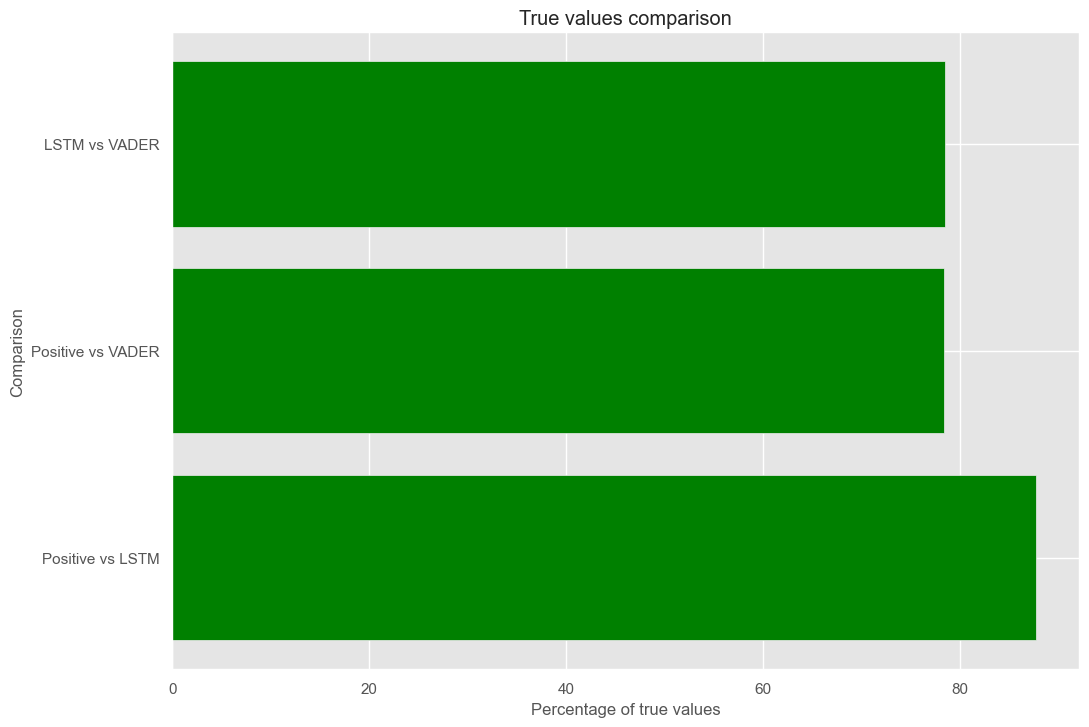

In [95]:
# Data
positive_vs_lstm = data['Positive_VS_LSTM_Positive'].value_counts()
positive_vs_vader = data['Positive_VS_VADER_Positive'].value_counts()
lstm_vs_vader = data['LSTM_Positive_VS_VADER_Positive'].value_counts()

# Compute percentages
pos_lstm_true_pct = positive_vs_lstm[0] / (positive_vs_lstm[0] + positive_vs_lstm[1]) * 100
pos_vader_true_pct = positive_vs_vader[0] / (positive_vs_vader[0] + positive_vs_vader[1]) * 100
lstm_vader_true_pct = lstm_vs_vader[0] / (lstm_vs_vader[0] + lstm_vs_vader[1]) * 100

# Plot
fig, ax = plt.subplots()
ax.barh(['Positive vs LSTM', 'Positive vs VADER', 'LSTM vs VADER'], 
        [pos_lstm_true_pct, pos_vader_true_pct, lstm_vader_true_pct], 
        color='green')
ax.set_xlabel('Percentage of true values')
ax.set_ylabel('Comparison')
ax.set_title('True values comparison')
plt.show()
